In [4]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import sklearn
import warnings
import re
import string

from pymongo  import MongoClient
from collections import Counter

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn import (linear_model, 
                     metrics,
                     preprocessing, 
                     model_selection, 
                     pipeline,
                    neural_network,)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from xgboost import XGBClassifier

from nltk.stem.snowball import FrenchStemmer


In [5]:
warnings.simplefilter("ignore")

## Connexion à la base de données MongoDB

In [6]:
client = MongoClient(host="localhost", port=27017)
db = client["PLDAC"]
avis = db["avis"]
df_avis = pd.DataFrame(list(avis.find()))

In [7]:
df_avis.dropna(subset=['comment'], inplace=True)

In [9]:
comments = df_avis['comment'].astype(str)
notes = df_avis['note'].round()

## Prétraitements

In [10]:
def delete_digit(doc):
    return re.sub('[0-9]+', '', doc)

In [11]:
def delete_ponctuation(doc):
    punc = string.punctuation 
    punc += '\n\r\t'
    return doc.translate(str.maketrans(punc, ' ' * len(punc)))

In [12]:
def stem(doc):
    stemmer = FrenchStemmer()
    tokens = nltk.word_tokenize(doc)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = " ".join(stemmed_tokens)
    return stemmed_text

In [13]:
comments = comments.str.lower()

In [14]:
comments = comments.map(delete_digit)

In [15]:
comments = comments.map(delete_ponctuation)

In [16]:
comments

0         lorsque le jeu est jeu  bon  réflexif  joli po...
1         comment continuer après un mega hit   simpleme...
2         vin d jeu  avec mariposas  elizabeth hargrave ...
4         très joli bijou que ce jeu là   le matériel  l...
5         mariposas est plutôt beau avec un grand platea...
                                ...                        
246516    le thème est sympa  les règles simples et faci...
246517    le jeu le plus mauvais auquel j ai eu l occasi...
246518         jamais rien compris aux règles en vo        
246520    zombie town met les joueurs dans la peau d un ...
246521    jeu indéniablement sympa  très visuel lorsque ...
Name: comment, Length: 201089, dtype: object

### Vocabulaire

In [17]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(comments)

print('Taille initiale du vocabulaire :', len(vectorizer.vocabulary_))

Taille initiale du vocabulaire : 136566


In [18]:
## Liste des mots les plus fréquents
corpus_clean = ' '.join(comments)
word_counts = Counter(corpus_clean.split())
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
sorted_words[:10]

['de', 'et', 'le', 'un', 'les', 'est', 'jeu', 'à', 'la', 'des']

# Classifieurs

In [23]:
np.random.seed(0)

###  Binarisation de notes

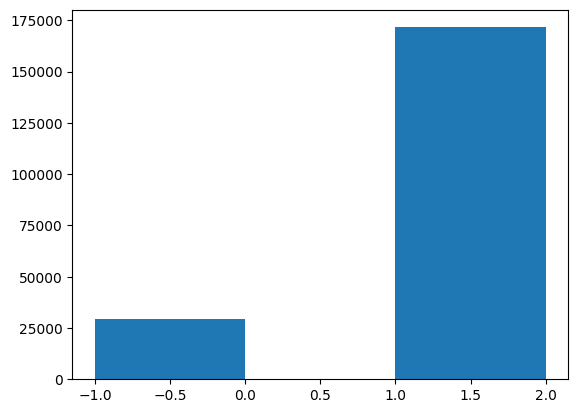

In [19]:
classes = [1 if note>5 else -1 for note in notes]
plt.hist(classes, bins=range(min(classes), max(classes) + 2, 1))
plt.show()

In [20]:
corpus_positif = ' '.join(comments)
word_counts = Counter(corpus_clean.split())
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
sorted_words[:10]

['de', 'et', 'le', 'un', 'les', 'est', 'jeu', 'à', 'la', 'des']

### Réequilibrage des clasees

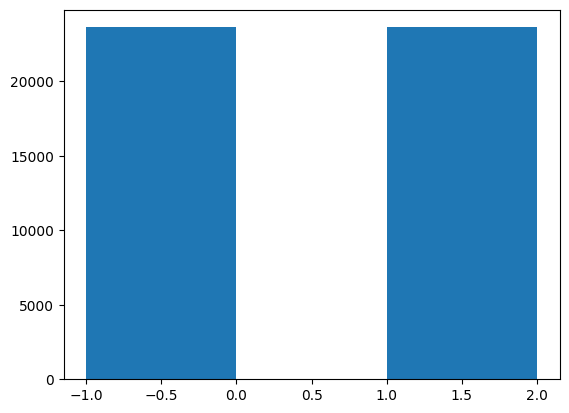

In [21]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(comments)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, classes, test_size=0.2, random_state=0)

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
plt.hist(y_resampled, bins=range(min(y_resampled), max(y_resampled) + 2, 1))
plt.show()

In [27]:
def classifieur(vectorizer):
    X = vectorizer.fit_transform(comments)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, classes, test_size=0.2, random_state=0)
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


    # Naïve Bayes
    nb_clf = MultinomialNB()
    nb_clf.fit(X_resampled, y_resampled)

    # Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, n_jobs=-1)
    lr_clf.fit(X_resampled, y_resampled)

    # Linear SVM
    svm_clf = LinearSVC(random_state=0, tol=1e-5)
    svm_clf.fit(X_resampled, y_resampled)
    
    #Random Forest
    rf_clf = RandomForestClassifier(n_estimators = 200, max_depth=2, random_state=0, n_jobs=-1)
    rf_clf.fit(X_resampled, y_resampled)

    pred_nb = nb_clf.predict(X_test)
    pred_lr = lr_clf.predict(X_test)
    pred_svm = svm_clf.predict(X_test)
    pred_rf = rf_clf.predict(X_test)

    nb_f1 = metrics.f1_score(y_test, pred_nb, average='weighted')
    lr_f1 = metrics.f1_score(y_test, pred_lr, average='weighted')
    svm_f1 = metrics.f1_score(y_test, pred_svm, average='weighted')
    rf_f1 = metrics.f1_score(y_test, pred_rf, average= 'weighted')

    # Trouver le meilleur modèle en fonction du f1-score
    best_model = ''
    if nb_f1 > lr_f1 and nb_f1 > svm_f1:
        best_model = 'Naïve Bayes'
        model = nb_clf
    elif lr_f1 > nb_f1 and lr_f1 > svm_f1:
        best_model = 'Logistic Regression'
        model = lr_clf
    else:
        best_model = 'SVM'
        model = svm_clf
    
    print(f"Best model: {best_model}")
    print(f"{best_model.capitalize()} accuracy: {metrics.accuracy_score(y_test, model.predict(X_test))}     f1-score: {metrics.f1_score(y_test, model.predict(X_test), average='weighted')}")

    # Obtenir les caractéristiques les plus importantes pour le meilleur modèle
    n = 10
    feature_weights = model.coef_[0]
    top_features = {
        'positive': [vectorizer.get_feature_names_out()[i] for i in feature_weights.argsort()[-n:][::-1]],
        'negative': [vectorizer.get_feature_names_out()[i] for i in feature_weights.argsort()[:n]]
    }

    
    print("Top 10 mots positifs: ", top_features['positive'])
    print("Top 10 mots négatifs: ", top_features['negative'])

### CountVectorizer

In [24]:
def count_vectorizer(**count_vectorizer_args):
    vectorizer = CountVectorizer(**count_vectorizer_args)
    return classifieur(vectorizer)

### TdfidfVectorizer

In [25]:
def tfidf_vectorizer(**tfidf_vectorizer_args):
    vectorizer = TfidfVectorizer(**tfidf_vectorizer_args)
    return classifieur(vectorizer)

## Variantes et évaluations

In [28]:
count_vectorizer()

Best model: Logistic Regression
Logistic regression accuracy: 0.8245810333681436     f1-score: 0.8432431742874559
Top 10 mots positifs:  ['excellent', 'régal', 'redemandent', 'bémol', 'cornéliens', 'bravo', 'mine', 'bluffant', 'redire', 'remarqué']
Top 10 mots négatifs:  ['décevant', 'ennuyeux', 'déception', 'préférez', 'manquant', 'arnaque', 'ennuyé', 'raté', 'oie', 'indigeste']


In [29]:
tfidf_vectorizer()

Best model: SVM
Svm accuracy: 0.8286339449997514     f1-score: 0.846531471052074
Top 10 mots positifs:  ['excellent', 'bémol', 'bravo', 'régal', 'recommande', 'adore', 'parfait', 'bon', 'efficace', 'excellente']
Top 10 mots négatifs:  ['déception', 'décevant', 'raté', 'ennuyeux', 'préférez', 'ennui', 'oie', 'pénible', 'pas', 'intérêt']


### Stopswords

In [30]:
count_vectorizer(stop_words=stopwords.words('french'))

Best model: Logistic Regression
Logistic regression accuracy: 0.8224178228653837     f1-score: 0.8413769683458457
Top 10 mots positifs:  ['excellent', 'régal', 'redemandent', 'bravo', 'bémol', 'bluffant', 'redire', 'volumineuse', 'foncez', 'parfaite']
Top 10 mots négatifs:  ['décevant', 'ennuyeux', 'déception', 'préférez', 'arnaque', 'ennuyé', 'raté', 'manquant', 'revendu', 'ennui']


In [31]:
tfidf_vectorizer(stop_words=stopwords.words('french'))

Best model: Logistic Regression
Logistic regression accuracy: 0.8257496643294048     f1-score: 0.8437163093821703
Top 10 mots positifs:  ['excellent', 'bon', 'bémol', 'adore', 'efficace', 'bien', 'bravo', 'parfait', 'plaisant', 'must']
Top 10 mots négatifs:  ['déception', 'intérêt', 'ennuyeux', 'ennui', 'décevant', 'ennuie', 'déçu', 'aucune', 'répétitif', 'bof']


### Stopswords et tous les mots qui apparaissent dans plus de 75% des documents sont ignorés

In [32]:
count_vectorizer(stop_words=stopwords.words('french'), max_df=.75)

Best model: Logistic Regression
Logistic regression accuracy: 0.8222189069570839     f1-score: 0.8411854735812151
Top 10 mots positifs:  ['excellent', 'régal', 'redemandent', 'bémol', 'bravo', 'bluffant', 'parfaite', 'redire', 'foncez', 'volumineuse']
Top 10 mots négatifs:  ['décevant', 'ennuyeux', 'déception', 'préférez', 'arnaque', 'ennuyé', 'raté', 'manquant', 'revendu', 'ennui']


In [33]:
tfidf_vectorizer(stop_words=stopwords.words('french'), max_df=.75)

Best model: Logistic Regression
Logistic regression accuracy: 0.826396141031379     f1-score: 0.844248330094017
Top 10 mots positifs:  ['excellent', 'bon', 'bémol', 'adore', 'efficace', 'bien', 'bravo', 'parfait', 'plaisant', 'must']
Top 10 mots négatifs:  ['déception', 'intérêt', 'ennuyeux', 'ennui', 'décevant', 'ennuie', 'déçu', 'aucune', 'répétitif', 'bof']


### Stopswords et tous les mots qui apparaissent dans plus de 20% des documents sont ignorés

In [34]:
count_vectorizer(stop_words=stopwords.words('french'), max_df=.2)

Best model: Logistic Regression
Logistic regression accuracy: 0.8177432990203392     f1-score: 0.837586055034438
Top 10 mots positifs:  ['redemandent', 'excellent', 'régal', 'bémol', 'bluffant', 'bravo', 'volumineuse', 'foncez', 'jouissif', 'redire']
Top 10 mots négatifs:  ['décevant', 'déception', 'ennuyeux', 'arnaque', 'préférez', 'ennuyé', 'revendu', 'raté', 'manquant', 'ennui']


In [35]:
tfidf_vectorizer(stop_words=stopwords.words('french'), max_df=.2)

Best model: Logistic Regression
Logistic regression accuracy: 0.8226664677507584     f1-score: 0.8411729198409544
Top 10 mots positifs:  ['excellent', 'bémol', 'adore', 'efficace', 'bravo', 'plaisant', 'agréable', 'gestion', 'must', 'parfait']
Top 10 mots négatifs:  ['déception', 'intérêt', 'ennuyeux', 'ennui', 'décevant', 'ennuie', 'aucune', 'bof', 'déçu', 'répétitif']


### Stopswords et les 100 termes les plus fréquents

In [ ]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100])

In [ ]:
tfidf_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100])

### Stopswords et les 1 000 termes les plus fréquents

In [ ]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:1000])

In [ ]:
tfidf_vectorizer(stop_words=stopwords.words('french')+sorted_words[:1000])

### Stopswords et les 10 000 termes les plus fréquents

In [ ]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:10000])

In [ ]:
tfidf_vectorizer(stop_words=stopwords.words('french')+sorted_words[:10000])

### Stopswords et les 40 000 termes les plus fréquents

In [ ]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:40000])

### Stopswords et les 100 000 termes les plus fréquents

In [ ]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100000])

In [ ]:
tfidf_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100000])

### Bigrammes

In [ ]:
count_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 2))

In [ ]:
tfidf_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 2))

In [ ]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100000], ngram_range=(1, 2))

In [ ]:
tfidf_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100000], ngram_range=(1, 2))

In [ ]:
count_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 2), max_df=0.5)

In [ ]:
tfidf_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 2), max_df=0.5)

### Trigrammes

In [ ]:
count_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 3))

In [ ]:
tfidf_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 3))

In [ ]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100000], ngram_range=(1, 3))

In [ ]:
tfidf_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100000], ngram_range=(1, 3))

In [ ]:
count_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 3), max_df=0.5)

In [ ]:
tfidf_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 3), max_df=0.5)

### Stemming

In [ ]:
# fonction de preprocessing : stemming 
f = lambda doc: stem(doc) 

In [ ]:
count_vectorizer(preprocessor=f)

In [ ]:
tfidf_vectorizer(preprocessor=f)

### Autres modeles

#### XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
classes = le.fit_transform(classes)


cv = CountVectorizer(stop_words=stopwords.words('french'))

X = cv.fit_transform(comments)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, classes, test_size=0.2, random_state=0)
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

report = metrics.classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

#### Neural network

In [ ]:
cv = CountVectorizer(stop_words=stopwords.words('french'))

X = cv.fit_transform(comments)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, classes, test_size=0.2, random_state=0)
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

model = neural_network.MLPClassifier()
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

report = metrics.classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df